There are three APIs for building models in Keras: Sequential; Functional; and Model Subclassing. Sequential is limited to a simple stack of layers and is the easiest to use. Functional focuses on graph-like model architectures, and is the most commonly used model-building API in keras. Model subclasssing is a low level option where everything is written from scratch. 

In [2]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([layers.Dense(64, activation="relu", name="my_first_layer"), layers.Dense(10, activation="softmax")], name="my_model")

# At this point the model isn't built yet, the input shape to the network isn't known!

model.build(input_shape=(None, 30))
model.summary()

model_2 = keras.Sequential()
model_2.add(keras.Input(shape=(3,)))
model_2.add(layers.Dense(64, activation="relu"))
model_2.summary()

# Summary is quite a useful debugging tool!

2022-06-17 14:44:41.856096: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-17 14:44:42.437390: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-17 14:44:42.437936: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-17 14:44:42.444014: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 my_first_layer (Dense)      (None, 64)                1984      
                                                                 
 dense (Dense)               (None, 10)                650       
                                                                 
Total params: 2,634
Trainable params: 2,634
Non-trainable params: 0
_________________________________________________________________
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 64)                256       
                                                                 
Total params: 256
Trainable params: 256
Non-trainable params: 0
_________________________________________________________________


In [3]:
# We start by declaring an input, which holds information about the shape and dtype of the data that the model will process. This is known as a symbolic tensor, it doesn't actually contain any data but it encodes the specifications
# of the actual tensors that the model will see. 
inputs = keras.Input(shape=(3,), name="my_input")

# Next we create a layer and call it on the input! All keras layers can be called on both real and symbolic tensors. When called on symbolic tensors they return another symbolic tensor with the updated tensor shape!
features = layers.Dense(64, activation="relu")(inputs)

outputs = layers.Dense(10, activation="softmax")(features)
model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 my_input (InputLayer)       [(None, 3)]               0         
                                                                 
 dense_2 (Dense)             (None, 64)                256       
                                                                 
 dense_3 (Dense)             (None, 10)                650       
                                                                 
Total params: 906
Trainable params: 906
Non-trainable params: 0
_________________________________________________________________


Multi-input, multi-output models!

In [4]:
vocabulary_size = 10000
num_tags = 100
num_departments = 4 

# Define the model inputs, title (text), text_body and tags!
title = keras.Input(shape=(vocabulary_size,), name="title")
text_body = keras.Input(shape=(vocabulary_size,), name="text_body")
tags = keras.Input(shape=(num_tags,), name="tags")

features = layers.Concatenate()([title, text_body, tags]) # Combine all the inputs into a single tensor, features, by concatenating them!
features = layers.Dense(64, activation="relu")(features) # Apply an intermediate layer to recombine input features into richer representations

# Define the models outputs! These are a priority value assigned to the IT ticket, and the department is which IT department the ticket is reffered to!
priority = layers.Dense(1, activation="sigmoid", name="priority")(features)
department = layers.Dense(num_departments, activation="softmax", name="department")(features)

model = keras.Model(inputs=[title, text_body, tags], outputs=[priority, department]) # Create a Functional model by specifying its inputs and outputs!

Training a multi-input multi-output model

2022-06-17 14:44:58.504477: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


40/40 [==============================] - 0s 3ms/step - loss: 28.3382 - priority_loss: 0.3268 - department_loss: 28.0113 - priority_mean_absolute_error: 0.4952 - department_accuracy: 0.0734


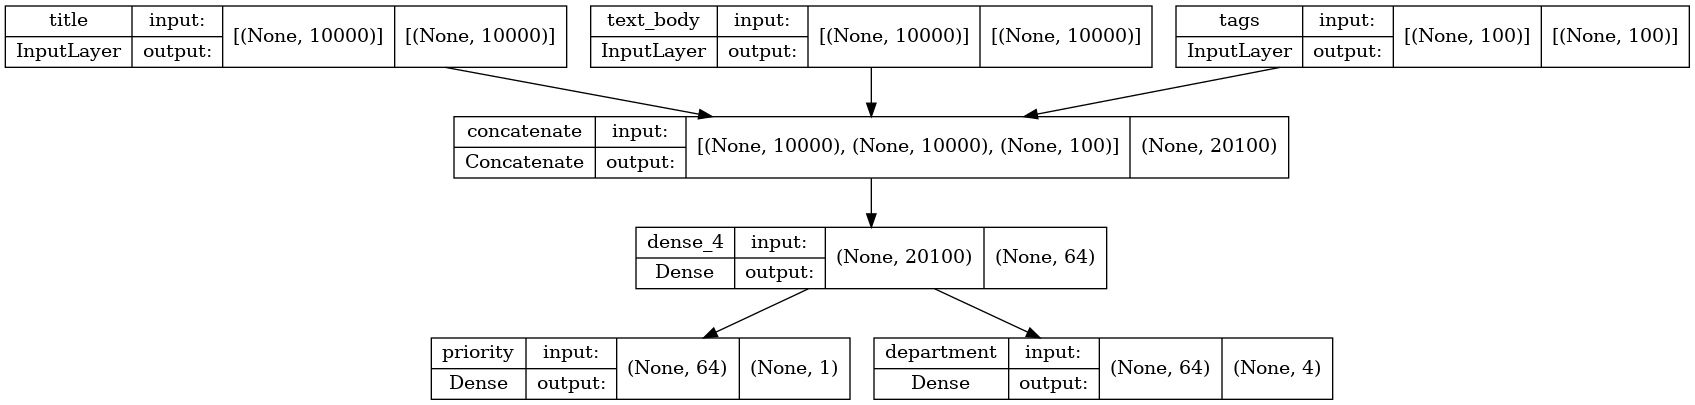

In [5]:
import numpy as np

num_samples = 1280

# Dummy input data
title_data = np.random.randint(0, 2, size=(num_samples, vocabulary_size))
text_body_data = np.random.randint(0, 2, size=(num_samples, vocabulary_size))
tags_data = np.random.randint(0, 2, size=(num_samples, num_tags))

# Dummy target data
priority_data = np.random.random(size=(num_samples, 1))
department_data = np.random.randint(0, 2, size=(num_samples, num_departments))

# Train the model on the data
model.compile(optimizer="rmsprop", loss=["mean_squared_error", "categorical_crossentropy"], metrics=[["mean_absolute_error"], ["accuracy"]])
model.fit([title_data, text_body_data, tags_data], [priority_data, department_data], epochs=1)
model.evaluate([title_data, text_body_data, tags_data], [priority_data, department_data])
priority_preds, department_preds = model.predict([title_data, text_body_data, tags_data])

# If we didn't want to rely on the input order given when the model constructor is ran to specify which data goes where, we can use the names we gave to the Input objects!
model.compile(optimizer="rmsprop", loss={"priority": "mean_squared_error", "department": "categorical_crossentropy"}, metrics={"priority": ["mean_absolute_error"], "department": ["accuracy"]})
model.fit({"title": title_data, "text_body": text_body_data, "tags": tags_data}, {"priority": priority_data, "department": department_data}, epochs=1)
model.evaluate({"title": title_data, "text_body": text_body_data, "tags": tags_data}, {"priority": priority_data, "department": department_data})
priority_preds, department_preds = model.predict({"title": title_data, "text_body": text_body_data, "tags": tags_data})

# Plot model is a powerful tool that can be useful for debugging!
keras.utils.plot_model(model, "ticket_classifier.png")
keras.utils.plot_model(model, "ticket_classifier.png", show_shapes=True)

# The "None" in the tensor shape represent the batch size: this model allows batches of any size.

In [6]:
# model.layers
model.layers[3].input
# model.layers[3].output

[<KerasTensor: shape=(None, 10000) dtype=float32 (created by layer 'title')>,
 <KerasTensor: shape=(None, 10000) dtype=float32 (created by layer 'text_body')>,
 <KerasTensor: shape=(None, 100) dtype=float32 (created by layer 'tags')>]

Since we have access to the layers we can do feature extraction! This is creating models that reuse intermediate features from another model. Say for example we wanted to add another output the the previous model (a diffuclty rating given to a ticket), we can do this by adding a classification layer based on the intermediate features produced by this model since we have access to them! 

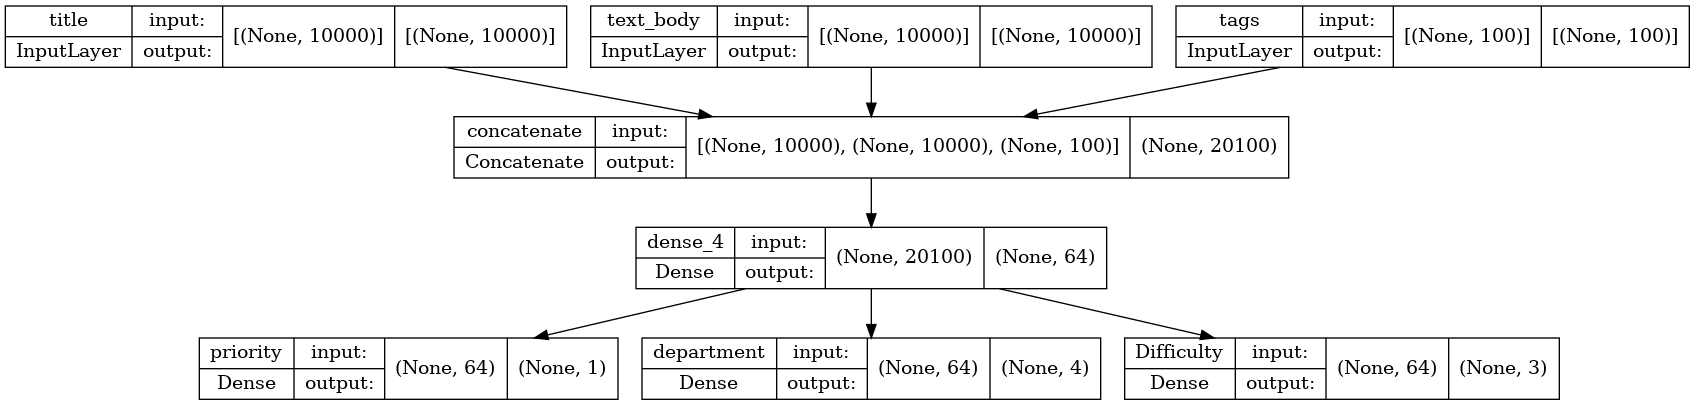

In [7]:
features = model.layers[4].output # This is our intermediate dense layer!
difficulty = layers.Dense(3, activation="softmax", name="Difficulty")(features)

new_model = keras.Model(inputs=[title, text_body, tags], outputs=[priority, department, difficulty])

# Lets plot our new model!

keras.utils.plot_model(new_model, "updated_ticket_classifier.png", show_shapes=True)

The last model-building pattern is Model subclassing. Lets rewrite the customer support ticket management model using a Model subclass!

In [8]:
class CustomerTicketModel(keras.Model): 

    def __init__(self, num_departments):
        super().__init__() # Important to remember to call the super() constructor!
        # Define sublayers in the constructor
        self.concat_layer = layers.Concatenate()
        self.mixing_layer = layers.Dense(64, activation="relu")
        self.priority_scorer = layers.Dense(1, activation="sigmoid")
        self.department_classifier = layers.Dense(num_departments, activation="softmax")

    def call(self, inputs):
        title = inputs["title"]
        text_body = inputs["text_body"]
        tags = inputs["tags"] 

        features = self.concat_layer([title, text_body, tags])
        features = self.mixing_layer(features)
        priority = self.priority_scorer(features)
        department = self.department_classifier(features)
        return priority, department

# Now we have defined our custom class, we can instantiate it!

model = CustomerTicketModel(num_departments=4)

priority, department = model({"title": title_data, "text_body": text_body_data, "tags": tags_data})
model.compile(optimizer="rmsprop", loss=["mean_squared_error", "categorical_crossentropy"], metrics=[["mean_absolute_error"], ["accuracy"]])
# The structure of the input data must match what is expected by the call() method!
# The structure of the target data must match what is returned by the call() method!
model.fit({"title": title_data, "text_body": text_body_data, "tags": tags_data}, [priority_data, department_data], epochs=1) 
model.evaluate({"title": title_data, "text_body": text_body_data, "tags": tags_data}, [priority_data, department_data])
priority_preds, department_preds = model.predict({"title": title_data, "text_body": text_body_data, "tags": tags_data})

40/40 [==============================] - 0s 2ms/step - loss: 30.1546 - output_1_loss: 0.3363 - output_2_loss: 29.8182 - output_1_mean_absolute_error: 0.5048 - output_2_accuracy: 0.0703


The Model subclassing workflow is the most flexible way to build a model. We can use it to build models that cannot be expressed as directed acyclic graphs of layers, we could have a call() method that uses layers inside a for loop or even calls them recursively! We could really do anything we wanted!

All models in Keras can smoothly interoperate with each other. For instance, we can use a subclassed layer od model in a functional model!

In [9]:
# Creating a functional model that includes a subclassed model!

class Classifier(keras.Model):

    def __init__(self, num_classes=2):
        super().__init__()
        if num_classes == 2:
            num_units = 1
            activation = "sigmoid"
        else:
            num_units = num_classes
            activation = "softmax"

        self.dense = layers.Dense(num_units, activation = activation)

    def call(self, inputs):
        return self.dense(inputs)

inputs = keras.Input(shape=(3,))
features = layers.Dense(64, activation="relu")(inputs)
outputs = Classifier(num_classes=10)(features)
model = keras.Model(inputs=inputs, outputs=outputs)

In [10]:
# Creating a subclassed model that includes a functional model!

inputs = keras.Input(shape=(64,))
outputs = layers.Dense(64, activation="sigmoid")(inputs)
binary_classifier = keras.Model(inputs=inputs, outputs=outputs)

class MyModel(keras.Model):

    def __init__(self, num_classes=2):
        super().__init__()
        self.dense = layers.Dense(64, activation="relu")
        self.classifier = binary_classifier

    def call(self, inputs):
        features = self.dense(inputs)
        return self.classifier(features)

model = MyModel()


If you can use the Functional API, (i.e. your network can be expressed as a directed acyclic graph of layers), it is recommened to use it! Since we can use subclassed layers with the Functional API it provides the best of both worls in regards to high development flexibility while retaining the advantages of the Functional API! 

In [19]:
# This is the compile(), fit(), evaluate() and predict() workflow we are already familiar with!

from tensorflow.keras.datasets import mnist

def get_mnist_model():
    inputs = keras.Input(shape=(28*28,))
    features = layers.Dense(512, activation="relu")(inputs)
    features = layers.Dropout(0.5)(features)
    outputs = layers.Dense(10, activation="softmax")(features)
    model = keras.Model(inputs, outputs)

    return model

(images, labels), (test_images, test_labels) = mnist.load_data()
images = images.reshape((60000, 28 * 28)).astype("float32") / 255
test_images = test_images.reshape((10000, 28 * 28)).astype("float32") / 255
train_images, val_images = images[10000:], images[:10000]
train_labels, val_labels = labels[10000:], labels[:10000]

model = get_mnist_model()
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model.fit(train_images, train_labels, epochs=3, validation_data=(val_images, val_labels))
test_metrics = model.evaluate(test_images, test_labels)
predictions = model.predict(test_images)

# There are a couple of ways we can customise this workflow: custom metrics; pass callbacks to the fit() method to schedule actions to be taken at specific points during training

Epoch 1/3
1563/1563 [==============================] - 3s 2ms/step - loss: 0.2961 - accuracy: 0.9124 - val_loss: 0.1454 - val_accuracy: 0.9589
Epoch 2/3
1563/1563 [==============================] - 2s 1ms/step - loss: 0.1633 - accuracy: 0.9541 - val_loss: 0.1340 - val_accuracy: 0.9631
Epoch 3/3
313/313 [==============================] - 0s 777us/step - loss: 0.1097 - accuracy: 0.9723


In [12]:
# Lets start with writing our own metrics

import tensorflow as tf

class RootMeanSquaredError(keras.metrics.Metric):

    # Like for layers, we have access to the add_weight() method! 
    def __init__(self, name="rsme", **kwargs):
        super().__init__(name=name, **kwargs)
        self.mse_sum = self.add_weight(name="mse_sum", initializer="zeros")
        self.total_samples = self.add_weight(name="total_samples", initializer="zeros", dtype="int32")

    # Implement the state update logic in update_state(). The y_true argument is the labels for one batch, y_pred is the predictions on this batch!
    def update_state(self, y_true, y_pred,  sample_weight=None):
        # To match our MNIST model, we expect categorical predictions and integer labels!
        y_true = tf.one_hot(y_true, depth=tf.shape(y_pred)[1])
        mse = tf.reduce_sum(tf.square(y_true - y_pred))
        self.mse_sum.assign_add(mse)
        num_samples = tf.shape(y_pred)[0]
        self.total_samples.assign_add(num_samples)

    # This method returns the current value of the metric!
    def result(self):
        return tf.sqrt(self.mse_sum / tf.cast(self.total_samples, tf.float32))

    # We also need a way to reset the metrics state without reinstantiating it!
    def reset_state(self):
        self.mse_sum.assign(0.)
        self.total_samples.assign(0)

# Lets use our custom metric!

model = get_mnist_model()
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy", metrics=["accuracy", RootMeanSquaredError()])
model.fit(train_images, train_labels, epochs=3, validation_data=(test_images, test_labels))
test_metrics = model.evaluate(test_images, test_labels)

Epoch 1/3
1563/1563 [==============================] - 4s 3ms/step - loss: 0.2947 - accuracy: 0.9120 - rsme: 7.1794 - val_loss: 0.1433 - val_accuracy: 0.9597 - val_rsme: 7.3811
Epoch 2/3
1563/1563 [==============================] - 4s 3ms/step - loss: 0.1670 - accuracy: 0.9523 - rsme: 7.3584 - val_loss: 0.1266 - val_accuracy: 0.9663 - val_rsme: 7.4130
Epoch 3/3
313/313 [==============================] - 0s 847us/step - loss: 0.1154 - accuracy: 0.9693 - rsme: 7.4341


In [13]:
# The keras callbacks API allows more control during fit()! We pass a callback object to the fit() method of a model which contains methods that the model can call at various points during training!
# There are a few different things that the callback API can do: Model checkpointing; early stopping; dynamically adjusting parameters during optimisation (things like learning rate!); logging/visualising training and validation metrics during training!

# Lets do an example using early stopping and checkpointing! Here we can hopefully avoid doing two training runs, the first to find where we overfit and the second to stop just as that starts!

callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2,), 
    keras.callbacks.ModelCheckpoint(filepath="checkpoint_path.keras", monitor="val_loss", save_best_only=True,)] # Here we create a list of the callbacks we want to do! EarlyStopping here stops training when the accuracy
                                                                                                                 # has stopped improving for two epochs, here ModelCheckpoint will save the model file each time val_loss has improved!
                                                                                                                 # This means we don't have to train twice!!

model = get_mnist_model()
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model.fit(train_images, train_labels, epochs=10, callbacks=callbacks_list, validation_data=(val_images, val_labels))


Epoch 1/10
1563/1563 [==============================] - 2s 1ms/step - loss: 0.2938 - accuracy: 0.9136 - val_loss: 0.1525 - val_accuracy: 0.9560
Epoch 2/10
1563/1563 [==============================] - 3s 2ms/step - loss: 0.1655 - accuracy: 0.9541 - val_loss: 0.1224 - val_accuracy: 0.9665
Epoch 3/10
1563/1563 [==============================] - 3s 2ms/step - loss: 0.1418 - accuracy: 0.9618 - val_loss: 0.1130 - val_accuracy: 0.9718
Epoch 4/10
1563/1563 [==============================] - 3s 2ms/step - loss: 0.1266 - accuracy: 0.9675 - val_loss: 0.1174 - val_accuracy: 0.9721
Epoch 5/10
1563/1563 [==============================] - 2s 1ms/step - loss: 0.1170 - accuracy: 0.9701 - val_loss: 0.1081 - val_accuracy: 0.9751
Epoch 6/10
1563/1563 [==============================] - 3s 2ms/step - loss: 0.1123 - accuracy: 0.9725 - val_loss: 0.1087 - val_accuracy: 0.9763
Epoch 7/10
1563/1563 [==============================] - 3s 2ms/step - loss: 0.1014 - accuracy: 0.9749 - val_loss: 0.1132 - val_accuracy:

In [14]:
# We can also save models manually after training as well. 
model.save('my_checkpoint_path')

# To reload a model use
model = keras.models.load_model("checkpoint_path.keras")

2022-06-17 14:45:55.017816: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: my_checkpoint_path/assets


We can also write our own callbacks in case we want to perform a specific action that isn't a performed by one the of the built-in callbacks! Callbacks are implem,ented by sub-classing the keras.callbacks.Callback class

Any of the following transparently named methods can be implemented which are called at various points in training!

on_epoch_begin(epoch, logs)

on_epoch_end(epoch, logs)

on_batch_begin(batch, logs)

on_batch_end(batch, logs)

on_train_begin(logs)

on_train_end(logs)

logs is a dictionary containing information about the previous batch, epoch or training run. epoch/batch is a integer index to that epoch/batch.


Epoch 1/10
1563/1563 [==============================] - 4s 2ms/step - loss: 0.2966 - accuracy: 0.9113 - val_loss: 0.1543 - val_accuracy: 0.9558
Epoch 2/10
1563/1563 [==============================] - 3s 2ms/step - loss: 0.1661 - accuracy: 0.9532 - val_loss: 0.1155 - val_accuracy: 0.9679
Epoch 3/10
1563/1563 [==============================] - 2s 1ms/step - loss: 0.1415 - accuracy: 0.9621 - val_loss: 0.1112 - val_accuracy: 0.9722
Epoch 4/10
1563/1563 [==============================] - 3s 2ms/step - loss: 0.1286 - accuracy: 0.9678 - val_loss: 0.1123 - val_accuracy: 0.9747
Epoch 5/10
1563/1563 [==============================] - 2s 2ms/step - loss: 0.1176 - accuracy: 0.9703 - val_loss: 0.1020 - val_accuracy: 0.9754
Epoch 6/10
1563/1563 [==============================] - 3s 2ms/step - loss: 0.1097 - accuracy: 0.9734 - val_loss: 0.1053 - val_accuracy: 0.9761
Epoch 7/10
1563/1563 [==============================] - 2s 2ms/step - loss: 0.1060 - accuracy: 0.9751 - val_loss: 0.1104 - val_accuracy:

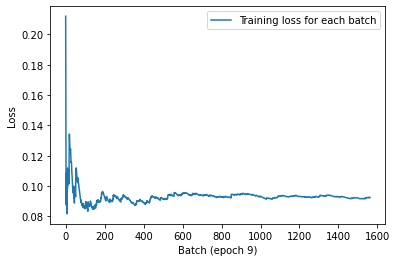

In [15]:
# Here is a simple example of saving per-batch loss values during training and saving a graph of these values at the end of each epoch.

from matplotlib import pyplot as plt

class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs):
        self.per_batch_losses = []

    def on_batch_end(self, batch, logs):
        self.per_batch_losses.append(logs.get("loss"))

    def on_epoch_end(self, epoch, logs):
        plt.clf()
        plt.plot(range(len(self.per_batch_losses)), self.per_batch_losses,
        label="Training loss for each batch")
        plt.xlabel(f"Batch (epoch {epoch})")
        plt.ylabel("Loss")
        plt.legend()
        plt.savefig(f"plot_at_epoch_{epoch}")
        self.per_batch_losses = []

model = get_mnist_model()
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model.fit(train_images, train_labels, epochs=10, callbacks=[LossHistory()], validation_data=(val_images, val_labels))

TensorBoard is a useful tool to help monitor what goes on during training!

In [16]:
model = get_mnist_model()
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
tensorboard = keras.callbacks.TensorBoard(log_dir="logs",)
model.fit(train_images, train_labels, epochs=10, validation_data=(val_images, val_labels), callbacks=[tensorboard])

Epoch 1/10
1563/1563 [==============================] - 2s 1ms/step - loss: 0.2941 - accuracy: 0.9124 - val_loss: 0.1577 - val_accuracy: 0.9549
Epoch 2/10
1563/1563 [==============================] - 2s 1ms/step - loss: 0.1646 - accuracy: 0.9538 - val_loss: 0.1280 - val_accuracy: 0.9669
Epoch 3/10
1563/1563 [==============================] - 2s 2ms/step - loss: 0.1403 - accuracy: 0.9619 - val_loss: 0.1104 - val_accuracy: 0.9718
Epoch 4/10
1563/1563 [==============================] - 2s 1ms/step - loss: 0.1269 - accuracy: 0.9674 - val_loss: 0.1103 - val_accuracy: 0.9738
Epoch 5/10
1563/1563 [==============================] - 3s 2ms/step - loss: 0.1167 - accuracy: 0.9702 - val_loss: 0.1165 - val_accuracy: 0.9723
Epoch 6/10
1563/1563 [==============================] - 2s 1ms/step - loss: 0.1094 - accuracy: 0.9727 - val_loss: 0.1162 - val_accuracy: 0.9768
Epoch 7/10
1563/1563 [==============================] - 2s 1ms/step - loss: 0.1063 - accuracy: 0.9747 - val_loss: 0.1248 - val_accuracy:

We can launch a local TensorBoard server using this command in the terminal: tensorboard --logdir /full_path_to_your_logs_dir, in our case this is tensorboard --logdir /logs, then navigate to the URL that the command returns!
We can also launch a TensorBoard using VSCode! Open the command pallate with Ctrl+Shift+P, then type >Python:Launch TensorBoard

The fit() method is really useful for supervised learning (where there are known labels) however it is not suited to generative learning, self-supervised learning and reinforcement learning, so sometimes it might be needed to write our own custom training logic. For a reminder, a typical training loop looks like:
- Run a forward pass inside a gradient tape to get a loss value for the current batch
- Retrieve the gradients of the loss w.r.t the model's weights
- Update the model's weights so as to lower the loss value on the current batch of data
- Repeat as many times as necessary

In this section we are going to reimplement fit()!

Some keras layers have different behaviours during training and inference, such as dropout layers! They take a boolean argument in their call() method! By extension, Functional and Sequential models also expose this training argument in their call() methods. We need to pass training=True when we call a Keras model during the forward pass! e.g. predictions=model(inputs, training=True). Also, when getting the gradients of the weights of the model we use tape.gradients(loss, model.trainable_weights) instead of tape.gradients(loss, model.weights)! Non-trainable weights are updated during a forward pass by the layers that own them, not during backpropagation! An example would be if we wanted a custom layer to keep a counter o how many batches it has processed, it would ++ during the forward pass and not be changes during backpropagation! 

In [17]:
def train_step(inputs, targets):
    with tf.GradientTape() as tape:
        predictions = model(inputs, training=True)
        loss = loss_fn(targets, predictions)
    gradients = tape.gradients(loss, model.trainable_weights)
    optimizer.apply_gradients(zip(model.trainable_weights, gradients))

    # We can also use metrics!

    metric = keras.metrics.SparseCategoricalAccuracy()
    targets = [0, 1, 2]
    predictions = [[1, 0, 0], [0, 1, 0], [0, 0, 1]]
    metric.update_state(targets, predictions)
    current_result = metric.result()
    print(f"result: {current_result:.2f}")

    values = [0, 1, 2, 3, 4]
    mean_tracker = keras.metrics.Mean()
    for value in values:
        mean_tracker.update_state(value)

    print(f"Mean of values: {mean_tracker.result():.2f}")

    # Remember to use metric.reset_state() at the start of a training epoch or at the start of evaluation!

Lets combine the forward pass, backwards pass and metrics into a fit()-like training step function that takes a batch of data and targets and returns the logs that would get displayed by the fit() progress bar.

In [24]:
model = get_mnist_model()

# Prepare the loss function, optimizer and list of metrics to monitor.
loss_fn = keras.losses.SparseCategoricalCrossentropy()
optimizer = keras.optimizers.RMSprop()
metrics = [keras.metrics.SparseCategoricalAccuracy()]
# Prepare a Mean metric tracker to keep track of the loss average
loss_tracking_metric = keras.metrics.Mean()

@tf.function
def train_step(inputs, targets):
    with tf.GradientTape() as tape:
        predictions = model(inputs, training=True) # Run a forward pass with training=True
        loss = loss_fn(targets, predictions)

    # Run a backwards pass using the trainable weights!
    gradients = tape.gradient(loss, model.trainable_weights)
    optimizer.apply_gradients(zip(gradients, model.trainable_weights))

    # Keep track of metrics
    logs = {}
    for metric in metrics:
        metric.update_state(targets, predictions)
        logs[metric.name] = metric.result()

    # Keep track of the loss average
    loss_tracking_metric.update_state(loss)
    logs["loss"] = loss_tracking_metric.result()
    return logs # Return the current values of the metrics and loss

# We need to reset the metrics at the start of each epoch and before running an evaluation
@tf.function
def reset_metrics():
    for metric in metrics:
        metric.reset_state()
    loss_tracking_metric.reset_state()

# Get some data!

training_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
training_dataset = training_dataset.batch(32)
epochs = 3

# This is our training loop!

for epoch in range(epochs):
    reset_metrics()
    for input_batch, targets_batch in training_dataset:
        logs = train_step(input_batch, targets_batch)
        print(f"Results at the end of epoch {epoch}")
        for key, value in logs.items():
            print(f"...{key}: {value:.4f}")

# Thats is fit() reimplemented! Lets now do evaluate()!

# This is our evaluation loop! This is basically train_step without the the code that changes the weights of the model! (everything involving gradient tape and the optimizer)

@tf.function
def test_step(inputs, targets):
    predictions = model(inputs, training=False) # Note we pass training=False in 
    loss = loss_fn(targets, predictions)

    logs = {}
    for metric in metrics:
        metric.update_state(targets, predictions)
        logs["val_" + metric.name] = metric.result()
        loss_tracking_metric.update_state(loss)
        logs["val_loss"] = loss_tracking_metric.result()

    return logs

val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_labels))
val_dataset = val_dataset.batch(32)
reset_metrics()

for inputs_batch, targets_batch in val_dataset:
    logs = test_step(inputs_batch, targets_batch)
print("Evaluation results:")
for key, value in logs.items():
    print(f"...{key}: {value:.4f}")

Results at the end of epoch 0
...sparse_categorical_accuracy: 0.0312
...loss: 2.5178
Results at the end of epoch 0
...sparse_categorical_accuracy: 0.1250
...loss: 2.3924
Results at the end of epoch 0
...sparse_categorical_accuracy: 0.2188
...loss: 2.2497
Results at the end of epoch 0
...sparse_categorical_accuracy: 0.3125
...loss: 2.0828
Results at the end of epoch 0
...sparse_categorical_accuracy: 0.3500
...loss: 1.9742
Results at the end of epoch 0
...sparse_categorical_accuracy: 0.3750
...loss: 1.8930
Results at the end of epoch 0
...sparse_categorical_accuracy: 0.3973
...loss: 1.8385
Results at the end of epoch 0
...sparse_categorical_accuracy: 0.4258
...loss: 1.7844
Results at the end of epoch 0
...sparse_categorical_accuracy: 0.4479
...loss: 1.7329
Results at the end of epoch 0
...sparse_categorical_accuracy: 0.4750
...loss: 1.6730
Results at the end of epoch 0
...sparse_categorical_accuracy: 0.5114
...loss: 1.6042
Results at the end of epoch 0
...sparse_categorical_accuracy: 0.5

It's pretty clear that our versions of fit(0) evaluate() run pretty slow compared to the keras versions! Thats because our code is execute line-by-line ("eagerly"), this makes it easier to debug but isn't ideal for performance. We can compile our TensorFlow code into a computation graph that can be globally optimized in a way that eager execution cannot. Its very simple, just by adding @tf.function before the function header! It's easier to debug without this, so just put it in after you code is working!

Instead of writing entirely our own training loop, we can write a custom training step function and keep the advantages of using the fit() function! (e.g. callbacks, distributed training etc...) We do this by overriding the train_step() method of the Model class! Here is a simple example where we create a new class the subclasses the keras.Model class, overrides the train_step(self, data) methodand implement a metrics property that tracks the models Metrics instances. This lets us to automatically call reset_state() on the models metrics at the start of each epoch and evaluate() so we don't have to do it by hand!

In [28]:
loss_fn = keras.losses.SparseCategoricalCrossentropy()
loss_tracker = keras.metrics.Mean(name="loss") # This will be used to track the average of per-batch losses during training and evaluation

class CustomModel(keras.Model):
    def train_step(self, data): # We overide the train_Step method! we don't need the @tf.function decorator, the framework does it for us!
        inputs, targets = data
        with tf.GradientTape() as tape:
            predictions = self(inputs, training=True) # use self instead of model since our model is the class itself
            loss = loss_fn(targets, predictions) 
        gradients = tape.gradient(loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_weights))

        loss_tracker.update_state(loss) # We update the loss tracker metric that tracks average of the loss

        return {"loss": loss_tracker.result()} # WE return the average loss so far by querying the loss tracker metric


    @property
    def metrics(self):
        return [loss_tracker] # Any metric that we want to reset across epochs should be listed here

# WE can now instantiate our custom model, compile it and train it using fit()!

inputs = keras.Input(shape=(28 * 28,))
features = layers.Dense(512, activation="relu")(inputs)
features = layers.Dropout(0.5)(features)
outputs = layers.Dense(10, activation="softmax")(features)
model = CustomModel(inputs, outputs)

model.compile(optimizer=keras.optimizers.RMSprop()) # By specifying the loss and metrics here we can get rid of them the top!
model.fit(train_images, train_labels, epochs=3)


Epoch 1/3
1563/1563 [==============================] - 2s 1ms/step - loss: 0.2943
Epoch 2/3
1563/1563 [==============================] - 2s 2ms/step - loss: 0.1639
Epoch 3/3
1563/1563 [==============================] - 3s 2ms/step - loss: 0.1387


In [29]:
# If we compile the model with a loss function and metrics we can avoid using loss_fn and loss_tracker!

class CustomModel(keras.Model):
    def train_step(self, data):
        inputs, targets = data
        with tf.GradientTape() as tape:
            predictions = self(inputs, training=True)
            loss = self.compiled_loss(targets, predictions) # Instead we use self.compiled_loss to calculate the loss
        gradients = tape.gradient(loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_weights)) 
        self.compiled_metrics.update_state(targets, predictions) # We can also use self.compiled_metrics.update_state fto update the models metrics instead of loss_tracker

        return {m.name: m.result() for m in self.metrics}


inputs = keras.Input(shape=(28 * 28,))
features = layers.Dense(512, activation="relu")(inputs)
features = layers.Dropout(0.5)(features)
outputs = layers.Dense(10, activation="softmax")(features)
model = CustomModel(inputs, outputs)

model.compile(optimizer=keras.optimizers.RMSprop(),
              loss=keras.losses.SparseCategoricalCrossentropy(),
              metrics=[keras.metrics.SparseCategoricalAccuracy()])
model.fit(train_images, train_labels, epochs=3)

Epoch 1/3
1563/1563 [==============================] - 3s 2ms/step - loss: 0.2945 - sparse_categorical_accuracy: 0.9125
Epoch 2/3
1563/1563 [==============================] - 4s 2ms/step - loss: 0.1639 - sparse_categorical_accuracy: 0.9533
Epoch 3/3
1563/1563 [==============================] - 3s 2ms/step - loss: 0.1387 - sparse_categorical_accuracy: 0.9628


Summary of what we learned in this chapter!

    - Different workflows in keras, gradually get more complex, all work together! (Sequentail, Functionaly, submodelling the Model() class)

    - Functional API is the most likely choise!

    - Simplest way to train and evaluate a model is fit() and evaluate()

    - We can use callbacks to monitor the modelduring fit()!

    - We can take full control of what fit() does by overriding the train_step() method!

    - We can write our own training loops entirely from scratch, useful for implementing brand-new training algorithms!